`Importar`

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from collections import deque
import math

`Funciones auxiliares`

In [2]:
def graficar_Lista(L, bfs=[], T=6, O=10):
    plt.figure(figsize=(T, T))
    N = -L[0][0][0] 
    
    [plt.plot([x, u], [y, v], color='gray', lw=1) for (x, y), vs in L for (u, v) in vs]
    [plt.plot(x, y, 'mo') for (x, y), _ in L]

    for (a, b) in bfs:
        plt.plot([a[0], b[0]], [a[1], b[1]], color='navy', lw=2)
        [plt.plot(x, y, color='navy', marker='o') for x, y in (a, b)]
        if abs(b[0]) == N or abs(b[1]) == N:
            plt.plot(b[0], b[1], 'ro', markersize=O)
    plt.plot(0, 0, 'ro', markersize=O)
    plt.axis('equal')
    plt.show()

In [3]:
def bfs(L):
    vecinos = dict(L)
    origen = (0,0)
    if origen not in vecinos:
        return [], 0

    xs = [v[0] for v,_ in L]; ys = [v[1] for v,_ in L]
    min_x, max_x = min(xs), max(xs); min_y, max_y = min(ys), max(ys)
    es_borde = lambda v: v[0] in (min_x, max_x) or v[1] in (min_y, max_y)

    visitado, cola, Lista_de_aristas = {origen: None}, deque([origen]), []
    encontrado = 0

    while cola:
        actual = cola.popleft()
        if actual != origen and es_borde(actual):
            encontrado = 1
            break
        for w in vecinos.get(actual, []):
            if w not in visitado:
                visitado[w] = actual
                cola.append(w)
                Lista_de_aristas.append((actual, w))
    return Lista_de_aristas, encontrado

In [4]:
def bfs_fast(L):
    vecinos = dict(L)
    origen = (0,0)
    if origen not in vecinos: return 0

    xs = [v[0] for v,_ in L]; ys = [v[1] for v,_ in L]
    min_x, max_x = min(xs), max(xs); min_y, max_y = min(ys), max(ys)
    es_borde = lambda v: v != origen and (v[0] in (min_x, max_x) or v[1] in (min_y, max_y))

    vis, cola = {origen}, deque([origen])
    while cola:
        a = cola.popleft()
        if es_borde(a): return 1
        for w in vecinos.get(a, []):
            if w not in vis:
                vis.add(w)
                cola.append(w)
    return 0

`Parte practica del Proyecto`

In [5]:
def ady(N, p):
    xy = np.array([(i,j) for i in range(-N,N+1) for j in range(-N,N+1)])
    ancho = 2*N + 1
    L = [(tuple(v), []) for v in xy]

    rand_right = np.random.rand(len(xy))
    rand_up    = np.random.rand(len(xy))

    for k, (i,j) in enumerate(xy):
        if i < N and rand_right[k] < p:
            vecino = k + ancho
            L[k][1].append(tuple(xy[vecino]))
            L[vecino][1].append((i,j))

        if j < N and rand_up[k] < p:
            vecino = k + 1
            L[k][1].append(tuple(xy[vecino]))
            L[vecino][1].append((i,j))
    return L

In [6]:
def expandir_grafo(L_nucleo, M, p):
    N = -L_nucleo[0][0][0]
    xy = np.array([(i,j) for i in range(-M,M+1) for j in range(-M,M+1)])
    ancho = 2*M + 1
    L = [(tuple(v), []) for v in xy]
    
    rand_right = np.random.rand(len(xy))
    rand_up    = np.random.rand(len(xy))
    t=0
    for k, (i,j) in enumerate(xy):
        if i < -N  or i > N or j < -N or j > N:
            if i < M and rand_right[k] < p:
                vecino = k + ancho
                L[k][1].append(tuple(xy[vecino]))
                L[vecino][1].append((i,j))

            if j < M and rand_up[k] < p:
                vecino = k + 1
                L[k][1].append(tuple(xy[vecino]))
                L[vecino][1].append((i,j))
        else:
            L[k][1].extend(L_nucleo[t][1])
            t += 1
    return L

`Construccion del Estimador`

In [7]:
# Flujo que entrega las hojas del arbol
def Flujo(ker, lista, step, p):
    M = -ker[0][0][0]
    count = 0
    hojas = []
    if bfs(ker)[1]==1:
        if lista == []:
            hojas.append(ker)
            return [1,hojas]
        else:
            for i in range(lista[0]):
                L_ady = expandir_grafo(ker, M+step, p)
                count_i,hojas_i = Flujo(L_ady, lista[1:], step, p)
                #if bfs(L_ady)[1]==1:
                count += count_i
                hojas.extend(hojas_i)
            return [count,hojas]
    else:
        hojas.append(ker)
        return [0,hojas]

In [8]:
def Flujo_niveles(ker, lista, step, p):
    niveles = len(lista) + 1
    A = [0] * niveles

    if bfs_fast(ker) == 1:
        A[0] = 1
    else:
        return A

    lista_grafos_nivel = [ker]
    
    for nivel in range(1, niveles):
        repeticiones = lista[nivel - 1]
        nuevos = []

        for g in lista_grafos_nivel:
            M = -g[0][0][0]

            for _ in range(repeticiones):
                g2 = expandir_grafo(g, M + step, p)
                nuevos.append(g2)

        conectados = sum(bfs_fast(g_aux) for g_aux in nuevos)
        A[nivel] = conectados

        lista_grafos_nivel = nuevos
    return np.array(A)

In [9]:
def estimador_suma_niveles(start, step, lista_m, p):
    suma = np.array([0]*len(lista_m))
    
    for _ in range(lista_m[0]):
        suma += Flujo_niveles(ady(start,p), lista_m[1:], step, p)
    return suma 

`Testeo_1`

In [18]:
np.random.seed(42)
L_nucleo = ady(2, 0.5)
L_expandido = expandir_grafo(L_nucleo, M=5, p=0.5)

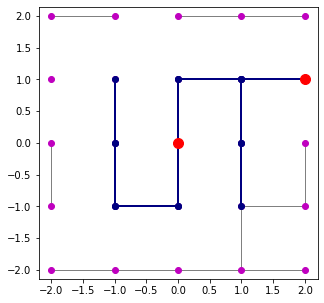

In [19]:
graficar_Lista(L_nucleo, bfs=bfs(L_nucleo)[0], T=5, O=10)

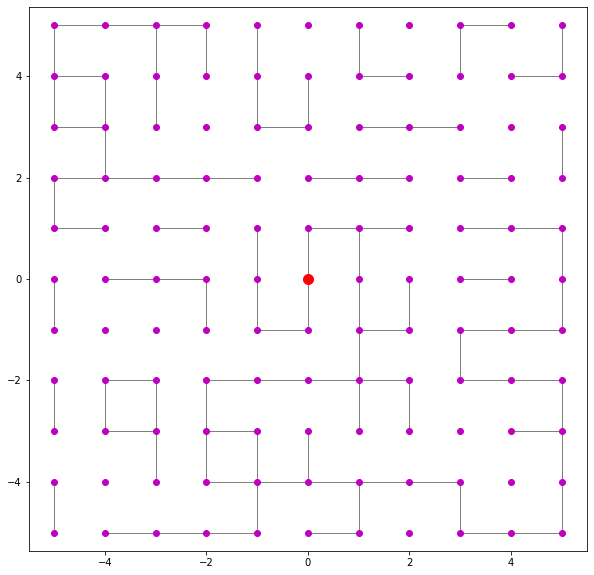

In [12]:
graficar_Lista(L_expandido, bfs=[], T=10, O=10)

`Testeo_11`

In [ ]:
np.random.seed(47)
ker = ady(1,0.35)
F = Flujo(ker,[2,2],1, 0.35)
print(F[0])

In [ ]:
graficar_Lista(ker,bfs(ker)[0], T=3)
graficar_Lista(F[1][0],bfs(F[1][0])[0], T=5)
graficar_Lista(F[1][1],bfs(F[1][1])[0], T=5)
graficar_Lista(F[1][2],bfs(F[1][2])[0], T=5)
graficar_Lista(F[1][3],bfs(F[1][3])[0], T=5)

`Construccion del Nuevo Estimador`

In [ ]:
def X_from_p(prob):
    a = math.floor(1/prob)
    b = math.ceil(1/prob)
    
    if random.random() < b - (1/prob):
        return a
    else:
        return b

In [ ]:
def R_lineal_c_new(p, lista_m = [5000]*2, start=5, step=5):
    L_puntos = []
    suma_0 = np.array([0]*len(lista_m))
    pi_0   = np.array([0]*len(lista_m))
    while True:
        suma_1 = estimador_suma_niveles(start, step, lista_m, p)
        pi_1 = np.array([math.prod(lista_m[:i+1]) for i in range(len(lista_m))])
        suma = suma_0 + suma_1
        pi = pi_0 + pi_1
        lista_s = suma / pi
        if np.any(lista_s <= 0):
            suma_0 = suma
            pi_0 = pi
            continue
        else:
            for j in range(len(lista_s)):
                L_puntos.append((step*j+start, math.log(1/lista_s[j])))
        break
    x = np.array([point[0] for point in L_puntos])
    y = np.array([point[1] for point in L_puntos])
    
    c = np.sum(x * y) / np.sum(x**2)
    return c

In [ ]:
def hijos(c,step):
    prob = math.exp(-c * step)
    n_hijos = 1/prob
    return (prob, n_hijos) 

In [ ]:
def F_estimador_new(p, lista_m = [5000]*2, start=4, step=1):
    L = len(lista_m)
    
    t_i__1 = time.time()
    c_test = R_lineal_c_new(p, lista_m, start, step)
    t_f__1 = time.time()
    
    lista_m_final  = [X_from_p(hijos(c_test,start)[0])]
    lista_m_final += [X_from_p(hijos(c_test, step)[0]) for _ in range(6)] # 14 # 7 # 2
    
    t_i___2 = time.time()
    c_final = R_lineal_c_new(p, lista_m_final, start, step)
    t_f___2 = time.time()
    return c_test, c_final, [t_f__1-t_i__1, t_f___2-t_i___2]

`Graficos Auxiliares`

In [ ]:
p= 1/7
lista_m = [300, 10] # [300] + [10]*7
start=1
step=2

L_puntos = []
suma_1 = estimador_suma_niveles(start, step, lista_m, p)
pi_1 = np.array([math.prod(lista_m[:i+1]) for i in range(len(lista_m))])
lista_s = suma_1 / pi_1
print(lista_s)

for j in range(len(lista_s)):
    L_puntos.append((step*j+start, math.log(1/lista_s[j])))

x = np.array([point[0] for point in L_puntos])
y = np.array([point[1] for point in L_puntos])
c = np.sum(x * y) / np.sum(x**2)
print(x)
print(y)
print(c)

# Recta ajustada
x_line = np.linspace(min(x), max(x), 100)
y_line = c * x_line

# Gráfico
plt.figure(figsize=(16, 8))
plt.scatter(x, y, marker='x', color='red', s=100, label="Datos")  # <-- X rojas
plt.plot(x_line, y_line, label=f"Ajuste lineal: y = {c:.4f}x")
#plt.plot(x_line, y_line)
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)
plt.title("Regresión lineal forzada por el origen (b = 0)", fontsize=20)
plt.legend(fontsize=20)
plt.grid(True, color='gray')
plt.show()

`Testeo_111`

In [ ]:
p = 1/7
c_test, c_final, Time = F_estimador_new(p, lista_m = [300, 20], start=1, step=2)
#
print(p,"|",Time[0],"|",Time[1],"|",Time[0]+Time[1],"|",c_test,"|", c_final)

In [ ]:
p = 0.997992
c_test, c_final, Time = F_estimador_new(p, lista_m = [10000, 1], start=2, step=3)
#
print(p,"|",Time[0],"|",Time[1],"|",Time[0]+Time[1],"|",c_test,"|", c_final)

In [ ]:
p = 0.3 #0.4979878048780488
c_test, c_final, Time = F_estimador_new(p, lista_m = [300, 10], start=1, step=2)
#
print(p,"|",Time[0],"|",Time[1],"|",Time[0]+Time[1],"|",c_test,"|", c_final)

`Datos_1`

In [ ]:
Lista_p = np.linspace(1, 0.51, 250)
L_pc_1 = []

t0 = time.time()
j=1
for p in Lista_p:
    t00 = time.time()
    #c_test, c_final, Time = F_estimador_new(p, lista_m = [10000, 1], start=2, step=3)
    c_test = R_lineal_c_new(p, lista_m = [10000, 1], start=2, step=3)
    L_pc_1.append((p, c_test, 0.0))
    
    # print("===","N°-->",j,"===") #
    # print(p,"|","-","|","-","|",time.time() - t00,"|",c_test,"|","-")
    # j += 1
Reloj = time.time() - t0
print("Tiempo --->", Reloj, "\n")
## 1589 segundos

In [ ]:
Lista_g1 =[]
for (p, c_test, c_final) in L_pc_1:
    # Lista_g1.append((p,c_test))
    Lista_g1.append((p,max(c_test,c_final)))

`Datos_2`

In [ ]:
Lista_p = np.linspace(0.5, 0.171, 170) #165 #500
L_pc_2 = []

t0 = time.time()
j=1
for p in Lista_p:
    t00 = time.time()
    c_test, c_final, Time = F_estimador_new(p, lista_m = [300, 10], start=1, step=2)
    L_pc_2.append((p, c_test, c_final))
    
    # print("===","N°-->",j,"===") #
    print(p,"|",Time[0],"|",Time[1],"|",time.time() - t00,"|",c_test,"|",c_final)
    # j += 1
Reloj = time.time() - t0
print("Tiempo --->", Reloj, "\n")
## 73.8 segundos

In [ ]:
Lista_g2 =[]
for (p, c_test, c_final) in L_pc_2:
    Lista_g2.append((p,0.5*(c_test+c_final)))
    # Lista_g2.append((p,max(c_test,c_final)))

`Datos_3`

In [ ]:
# Lista_p = np.linspace(0.17, 0.0, 85)
Lista_p = np.linspace(0.17, 0.030357142857142868, 70)
L_pc_3 = []

t0 = time.time()
j=1
for p in Lista_p:
    t00 = time.time()
    c_test, c_final, Time = F_estimador_new(p, lista_m = [300, 20], start=1, step=2)
    L_pc_3.append((p, c_test, c_final))
    
    # print("===","N°-->",j,"===") #
    # print(p,"|",Time[0],"|",Time[1],"|",time.time() - t00,"|",c_test,"|",c_final)
    # j += 1
Reloj = time.time() - t0
print("Tiempo --->", Reloj, "\n")
## 6162.9 segundos

In [ ]:
Lista_g3 =[]
for (p, c_test, c_final) in L_pc_3:
    Lista_g3.append((p,0.5*(c_test+c_final)))
    #Lista_g3.append((p,max(c_test,c_final)))

`Datos_4`

In [ ]:
# Lista_p = np.linspace(0.17, 0.0, 85)
Lista_p = np.linspace(0.03035714285714286, 0.0, 15)
L_pc_4 = []

t0 = time.time()
j=1
for p in Lista_p:
    t00 = time.time()
    c_test, c_final, Time = F_estimador_new(p, lista_m = [300, 20], start=1, step=2)
    L_pc_4.append((p, c_test, c_final))
    
    # print("===","N°-->",j,"===") #
    print(p,"|",Time[0],"|",Time[1],"|",time.time() - t00,"|",c_test,"|",c_final)
    # j += 1
Reloj = time.time() - t0
print("Tiempo --->", Reloj, "\n")

`Grafico final de F(p)=c`

In [ ]:
L = Lista_g1 + Lista_g2 + Lista_g3 #+ Lista_g4

x = [p[0] for p in L]
y = [p[1] for p in L]

plt.figure(figsize=(16, 8))

plt.plot(
    x, y,
    color='navy',
    linewidth=2,
    label="Datos"
)

# Índices de los puntos que quieres marcar con 'x'
indices_marcados = [0, 254, 564, 634]  # <-- cambia estos

plt.plot(
    x, y,
    linestyle='None',      # sin línea
    marker='x',
    markersize=12,
    markeredgecolor='red',
    markevery=indices_marcados
)

plt.xlabel("p", fontsize=20)
plt.ylabel("c", fontsize=20)
plt.title("Gráfico de F(p)=c", fontsize=20)
plt.legend(fontsize=20)
plt.grid(True, color='gray')

plt.show()